In [11]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPModel,AutoTokenizer
import pandas as pd
import random
from bs4 import BeautifulSoup

In [12]:


model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")


# from transformers import AutoTokenizer, CLIPTextModel

# model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
# tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [56]:
from transformers import AutoTokenizer, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [86]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(images=image, return_tensors="pt")

image_features = model.get_image_features(**inputs)

In [13]:

"""
get text features
get predictions
get dataframe for results
"""

def _normalise_features(features):
    features /= features.norm(dim=-1, keepdim=True)
    return features
    

def _get_text_features(texts: list):
    inputs = tokenizer(text=texts, padding=True, return_tensors="pt")
    text_features = model.get_text_features(**inputs)
    return _normalise_features(text_features)

def _get_image_features(image, processor):
    inputs = processor(images=image, return_tensors="pt")
    image_features = model.get_image_features(**inputs)
    return _normalise_features(image_features)

In [95]:
a = _get_text_features(['this is a puppy','this is a cat'])
b = _get_text_features(['this is a dog'])
c = _get_image_features(image,processor)

In [102]:
def _calculate_similarity(input_features, output_features):
    similarity = (100.0 * input_features @ output_features.T).softmax(dim=-1)
    values, indices = similarity.topk(len(output_features))
#     values = [i.item() for i in values]
    return similarity


In [103]:
_calculate_similarity(b,a)

tensor([[0, 1]])

# Classification

In [64]:
def _get_random_image():
    # Set the URL of a random image to fetch
    url = f'https://picsum.photos/600'
    image = Image.open(requests.get(url, stream=True).raw)
    return image

In [81]:
def _calculate_image_features(image: list):
    inputs = processor(images=image, return_tensors="pt")
    image_features = model.get_image_features(**inputs)
    return image_features.detach().numpy()

In [4]:
def _calculate_text_features(text: list):
    inputs = tokenizer(text, padding=True, return_tensors="pt")
    text_features = model.get_text_features(**inputs)
    return text_features.detach().numpy()

In [34]:
def classify_image(texts: list, images):
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  
    probs = logits_per_image.softmax(dim=1) 
    return 

In [ ]:
def _results_to_dataframe(probs,texts):
    df_result = pd.DataFrame(probs[0].detach().numpy(),texts).reset_index()
    df_result.columns=['labels','probabilities']
    return df_result

# Image Clustering

In [3]:
import requests
from bs4 import BeautifulSoup
import os

In [13]:
def _show_image(url):
    # Set the URL of a random image to fetch
    image = Image.open(requests.get(url, stream=True).raw)
    return image

In [10]:
def _get_soup():
    response = requests.get('https://unsplash.com/t/travel')
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup

In [11]:
def _get_image_urls_from_soup(soup):
    unplash_urls = []
    for img in soup.find_all('img'):
        img_url = img['src']
        if 'https://images.unsplash.com/photo' in img_url:
            unplash_urls.append(img_url)
    return unplash_urls

In [16]:
def _get_random_image_url(unplash_urls):
    index = random.randint(0,len(unplash_urls))
    return unplash_urls[index]

In [14]:
x = _get_image_urls_from_soup(_get_soup())

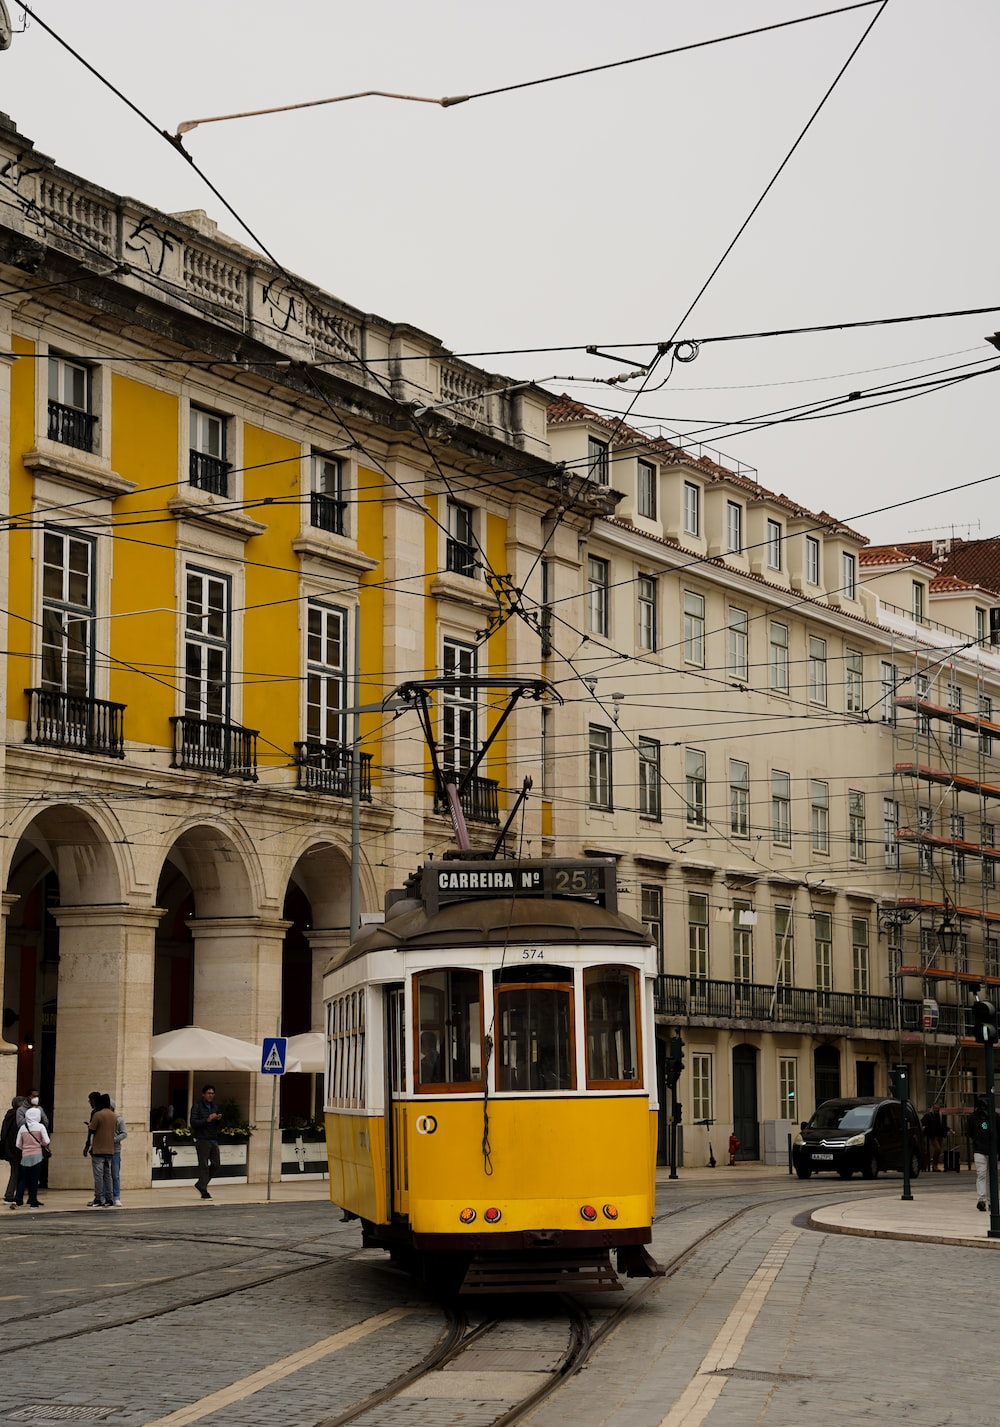

In [18]:
_show_image(_get_random_image_url(x))

# Text Classification

In [19]:
from backend import *

In [108]:
cats = "http://images.cocodataset.org/val2017/000000039769.jpg"
dogs = 'https://paradepets.com/.image/t_share/MTkxMzY1Nzg4NjczMzIwNTQ2/cutest-dog-breeds-jpg.jpg'
image_cats = Image.open(requests.get(cats, stream=True).raw)
image_dogs = Image.open(requests.get(dogs, stream=True).raw)

In [109]:
images_ = [image_cats,image_dogs]

In [105]:
def classify_image(texts: list, images: list, processor, model):
    """
    Classify a list of images using a list of texts as prompts.

    Args:
        texts (list): A list of texts to use as prompts for image classification.
        images (list): A list of images to classify.
        processor: The CLIP processor to use.
        model: The CLIP model to use.

    Returns:
        A numpy array of the classification probabilities for the input images.
    """
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    return probs

In [111]:
classify_image(['cats','dogs'],images_[0],processor, model)

tensor([[0.9963, 0.0037]], grad_fn=<SoftmaxBackward0>)

## BBC

In [4]:
def _get_soup(topic):
    response = requests.get(f'https://www.bbc.co.uk/{topic}')
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup

In [53]:
soup_news = _get_soup('business')

In [54]:
def get_bbc_headlines_from_soup(soup):
    bbc_headlines = []
    # Find all the headlines using the "h3" tag and "gs-c-promo-heading" class
    headlines = soup.find_all("p")

    # Loop through each headline and print the text
    for headline in headlines:
        try:
            bbc_headlines.append(headline.get_text())
        except:
            pass
    return [i for i in bbc_headlines if len(i.split()) >=7]

In [55]:
get_bbc_headlines_from_soup(soup_news)

['The Royal Horticultural Society says demand has risen as shops limit sales of some fresh produce.',
 'The High Street retailer says customer accounts and databases are not affected by the incident.',
 'CRH says it is considering moving its main share listing in a further blow to the UK stock market.',
 'The founder of the MoneySavingExpert website is calling on the government to do more to help.',
 'Union members at a distribution centre in Coventry take a third day of action in a row over pay.',
 'The coffee chain follows other retailers in boosting pay during a labour shortage.',
 'The High Street retailer says customer accounts and databases are not affected by the incident.',
 'CRH says it is considering moving its main share listing in a further blow to the UK stock market.',
 'The founder of the MoneySavingExpert website is calling on the government to do more to help.',
 'Sources in the energy industry say that firms have already priced in support for bills continuing.',
 'Dar

In [44]:
soup_news.find_all("p")[3].text

'Journalist Isabel Oakeshott says it was in the "national interest" to publish ex-health secretary\'s texts.'

In [ ]:
gs-c-promo-summary gel-long-primer gs-u-mt nw-c-promo-summary gs-u-display-none gs-u-display-block@m

In [17]:
soup_news.find_all("p")

[<p style="position: absolute; top: -999em"><img alt="" height="1" src="https://a1.api.bbc.co.uk/hit.xiti?&amp;col=1&amp;from=p&amp;ptag=js&amp;s=598253&amp;p=news.page&amp;x1=[urn:bbc:cps:b5c53243-a695-e059-e040-850a02846523]&amp;x2=[responsive]&amp;x3=[bbc_website]&amp;x4=[en]&amp;x7=[index-home]&amp;x8=[reverb-3.6.1-nojs]&amp;x11=[news_ps]&amp;x12=[news]" width="1"/></p>,
 <p class="nw-c-notification-text gs-u-mt++ gs-u-mb gel-long-primer" id="nw-c-notification-text">Start by setting your nation for news</p>,
 <p class="id-cta-wrapper" id="id4-cta-75d2951b-b4b5-4714-a5e9-96c5ab0dd388"><a class="id-cta-button" data-bbc-container="id-cta" data-bbc-event-type="click" data-bbc-ignore-views="1" data-bbc-metadata='{"id-cta-type": "embedded"}' data-bbc-source="responsive_web" data-bbc-title="id-cta-sign-in" href="https://session.bbc.co.uk/session?ptrt=https%3A%2F%2Fwww.bbc.co.uk%2Fnews&amp;context=news&amp;userOrigin=https%3A%2F%2Fwww.bbc.co.uk%2Fnews"><svg class="id-cta-icon" height="1em"

# Conceptual Captioning

In [1]:
import requests
from bs4 import BeautifulSoup
import os
import re
import pandas as pd

In [27]:
import umap.umap_ as umap

In [28]:
def _calculate_text_features(text: list):
    inputs = tokenizer(text, padding=True, return_tensors="pt")
    text_features = model.get_text_features(**inputs)
    return text_features.detach().numpy()

In [83]:
df = pd.read_csv('/Users/saho/Desktop/Image_Labels_Subset_Train_GCC-Labels-training.tsv',header=None,
                usecols=[0,1])

In [84]:
df[0] = df[0].apply(lambda x:  x.split('\thttp')[0].replace(".","").strip())

In [85]:
cats = ['vehicle','sports','nature','illustration','property', 'musician','food']

In [86]:
df = df[df[1].isin(cats)]

In [89]:
df = df.groupby(1).sample(500)

In [90]:
df['embed'] = df[0].apply(lambda x: _calculate_text_features([x]))


In [91]:
df['embed'] = df['embed'].apply(lambda x: x[0])

In [92]:
df.columns = ['caption','category','embed']

In [81]:
df = df.iloc[:7000]

In [93]:
df.to_csv('test.csv')

In [96]:
df

,caption,category,embed
316416,another historian shared how plants can be use...,food,"[0.023720741, 0.4621839, -0.12769923, -0.12790..."
436541,dish on the red background,food,"[-0.32503748, 0.09001547, 0.15438613, -0.22589..."
1748235,recipes with pasta and no meat,food,"[-0.37276757, -0.11273353, 0.19985875, -0.2466..."
1835350,pizza on the white background stock photo,food,"[-0.00612393, -0.38401675, 0.08508352, 0.25156..."
1027039,dish -- an easy dessert that 's healthy enough...,food,"[-0.2406637, 0.100688964, -0.11210142, -0.0493..."
...,...,...,...
1624248,flying pirate ship in front,vehicle,"[0.07623996, -0.07050568, -0.27828294, -0.2654..."
27922,another classic car in parking lot,vehicle,"[0.0050924346, 0.12986675, 0.16837889, -0.2709..."
1236714,yellow tram on the street,vehicle,"[0.040603966, -0.008487619, -0.14916795, -0.01..."
252814,the gold wheels look really nice,vehicle,"[0.018060386, -0.13577974, 0.1487715, 0.251093..."


In [202]:
def read_in_cached_clip_embeddings(path):
    df = pd.read_csv(path)
    return df

# Add User Embedding

In [189]:
user_input = 'soccer worldcup'

In [190]:
user_embedding = _calculate_text_features([user_input])[0]

In [ ]:
def update_dataframe(df_categories_clip, df_user_input_clip):
    df = pd.concat([df_categories_clip, df_user_input_clip], ignore_index=True)
    return df

In [ ]:
def get_user_input_dataframe(user_input,user_embedding):
    df_user_input = pd.DataFrame({'caption': [user_input], 'category': ['user'],'embed':[user_embedding]})
    return df_user_input

In [ ]:
def delete_row(df, _index):
    return df.iloc[:_index]

In [193]:
import numpy

In [194]:
def get_umap_dataframe(model, embeddings):
    arrays = [i.reshape(1, -1) for i in embeddings]
    df_embed_decomp = pd.DataFrame(model.fit_transform(numpy.concatenate(arrays, axis=0)))
    df_embed_decomp.columns = ['x','y']
    return df_embed_decomp

In [195]:
%%time
df_embed_decomp_umap = decompose_embeddings(umap.UMAP(),df.embed.values)

CPU times: user 20.6 s, sys: 1.25 s, total: 21.9 s
Wall time: 8.82 s


In [196]:
df_embed_decomp_umap.shape

(3501, 2)

In [197]:
import plotly.express as px

In [198]:
df_embed_decomp_umap['size'] = 10

In [199]:
df_embed_decomp_umap.loc[3500,'size'] = 100


In [200]:
df_embed_decomp_umap['caption'] = df['caption']
df_embed_decomp_umap['category'] = df['category']

In [201]:
fig = px.scatter(df_embed_decomp_umap,'x','y',hover_data=['category','caption'],color='category',opacity=0.7,size='size')


fig.update_layout(
    margin=dict(l=40, r=40, t=40, b=40), # set the margins of the plot

    title='My Scatter Plot', # set the title of the plot
  
    font=dict(family='Arial', size=12), # set the font family and size
    showlegend=True, # show the legend
    legend_title='Caption Category', # set the title of the legend
    template = 'plotly_white',
    legend_font=dict(family='Arial', size=10), # set the font family and size of the legend

)
fig.update_traces(hovertemplate="<b>Category:</b> %{customdata[0]}<br>" +
                                "<b>Caption:</b> %{customdata[1]}<br>")



fig.show()

In [513]:
df_embed_decomp_umap

,x,y,size
0,2.617682,0.863417,3
1,2.548916,-1.899409,3
2,1.710451,-2.873018,3
3,1.221851,3.485189,3
4,2.711104,-3.265507,3
...,...,...,...
6996,4.311244,4.661416,3
6997,5.389724,5.409206,3
6998,4.035017,3.600979,3
6999,5.466600,5.771626,3
